[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sunitha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Random Forest Training Time: 8.28 seconds
XGBoost Training Time: 8.72 seconds
SVM Training Time: 0.17 seconds


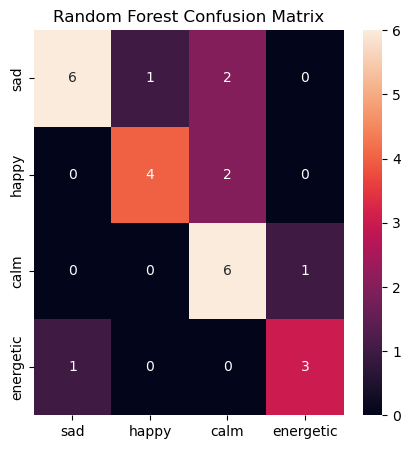

              precision    recall  f1-score   support

         sad       0.86      0.67      0.75         9
       happy       0.80      0.67      0.73         6
        calm       0.60      0.86      0.71         7
   energetic       0.75      0.75      0.75         4

    accuracy                           0.73        26
   macro avg       0.75      0.74      0.73        26
weighted avg       0.76      0.73      0.73        26

#### Random Forest accuracy =  73.1%


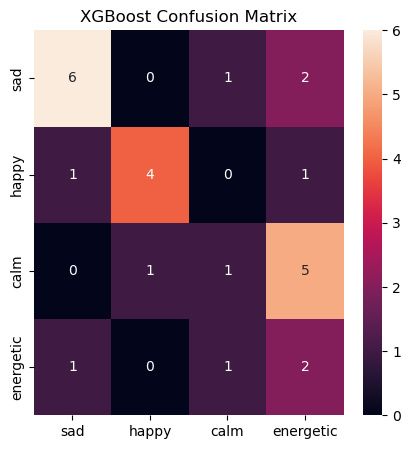

              precision    recall  f1-score   support

         sad       0.75      0.67      0.71         9
       happy       0.80      0.67      0.73         6
        calm       0.33      0.14      0.20         7
   energetic       0.20      0.50      0.29         4

    accuracy                           0.50        26
   macro avg       0.52      0.49      0.48        26
weighted avg       0.56      0.50      0.51        26

#### XGBoost accuracy =  50.0%


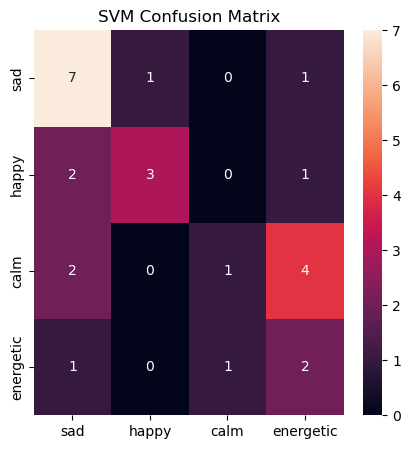

              precision    recall  f1-score   support

         sad       0.58      0.78      0.67         9
       happy       0.75      0.50      0.60         6
        calm       0.50      0.14      0.22         7
   energetic       0.25      0.50      0.33         4

    accuracy                           0.50        26
   macro avg       0.52      0.48      0.46        26
weighted avg       0.55      0.50      0.48        26

#### SVM accuracy =  50.0%


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # Importing SVM
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import nltk
import re
from nltk.corpus import stopwords
from xgboost import XGBClassifier
import time  # Import the time module

# Load dataset
df = pd.read_csv('lyrics_166.csv')

# Map mood labels to integers
mood_mapping = {'happy': 1, 'sad': 0, 'calm': 2, 'energetic': 3}
df['mood'] = df['mood'].map(mood_mapping)

# Prepare features and labels
data_X = df['lyrics'].values
data_Y = df['mood'].values

# Download NLTK stopwords if not already done
nltk.download('stopwords')

# Initialize the Porter Stemmer
porter_stemmer = nltk.stem.porter.PorterStemmer()

# Get the default English stop words from NLTK
stop_words = stopwords.words('english')

# Stem the stop words so they are consistent with your tokenization
stemmed_stop_words = [porter_stemmer.stem(word) for word in stop_words]

# Custom tokenizer with stemming and stop words removal
def porter_tokenizer(text, stemmer=porter_stemmer, stop_words=stemmed_stop_words):
    lower_txt = text.lower()
    tokens = nltk.wordpunct_tokenize(lower_txt)
    stems = [stemmer.stem(t) for t in tokens]
    no_punct = [s for s in stems if re.match('^[a-zA-Z]+$', s) is not None]
    return [word for word in no_punct if word not in stop_words]

# Build TfidfVectorizer with only unigrams for faster processing
tfidf = TfidfVectorizer(
    encoding='utf-8',
    decode_error='replace',
    strip_accents='unicode',
    analyzer='word',
    tokenizer=porter_tokenizer,
    token_pattern=None,
    ngram_range=(1, 1)  # Only unigrams for faster processing
)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.1, random_state=0, stratify=data_Y)

# Fit and transform the training data using TfidfVectorizer
train_vectors = tfidf.fit_transform(X_train)  # Fit on training data
test_vectors = tfidf.transform(X_test)  # Transform the test data

# Apply RandomOverSampler to handle class imbalance (no need for dense conversion)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(train_vectors, y_train)

# Reduced hyperparameter space for faster testing
param_grid_rf = {'n_estimators': [50], 'max_depth': [10], 'min_samples_split': [2]}
grid_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=0), param_grid_rf, scoring='accuracy', cv=3, n_jobs=-1)

# Measure time for Random Forest training
start_time_rf = time.time()  # Start timer
grid_rf.fit(X_resampled, y_resampled)
end_time_rf = time.time()  # End timer
print(f"Random Forest Training Time: {end_time_rf - start_time_rf:.2f} seconds")

# Best Random Forest Model
classifier_rf = grid_rf.best_estimator_

# Reduced hyperparameter space for faster testing
param_grid_xgb = {'n_estimators': [50], 'max_depth': [6], 'learning_rate': [0.3]}
grid_xgb = GridSearchCV(XGBClassifier(random_state=0, n_jobs=-1), param_grid_xgb, scoring='accuracy', cv=3, n_jobs=-1)

# Measure time for XGBoost training
start_time_xgb = time.time()  # Start timer
grid_xgb.fit(X_resampled, y_resampled)
end_time_xgb = time.time()  # End timer
print(f"XGBoost Training Time: {end_time_xgb - start_time_xgb:.2f} seconds")

# Best XGBoost Model
classifier_xgb = grid_xgb.best_estimator_

# SVM Model with a reduced hyperparameter space for faster testing
param_grid_svm = {'C': [1], 'kernel': ['linear'], 'gamma': ['scale']}
grid_svm = GridSearchCV(SVC(class_weight='balanced', random_state=0), param_grid_svm, scoring='accuracy', cv=3, n_jobs=-1)

# Measure time for SVM training
start_time_svm = time.time()  # Start timer
grid_svm.fit(X_resampled, y_resampled)
end_time_svm = time.time()  # End timer
print(f"SVM Training Time: {end_time_svm - start_time_svm:.2f} seconds")

# Best SVM Model
classifier_svm = grid_svm.best_estimator_

# Define prediction evaluation function
def prediction_evaluation(model_name, model, test_X, test_Y):
    y_pred = model.predict(test_X)
    labels = [0, 1, 2, 3]  # 'sad', 'happy', 'calm', 'energetic'
    cm = confusion_matrix(test_Y, y_pred, labels=labels)
    
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["sad", "happy", "calm", "energetic"], yticklabels=["sad", "happy", "calm", "energetic"])
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    
    print(classification_report(test_Y, y_pred, target_names=["sad", "happy", "calm", "energetic"], labels=labels, zero_division=0))
    print(f"#### {model_name} accuracy = {100.0 * model.score(test_X, test_Y):5.1f}%")

# Evaluate the Random Forest model
prediction_evaluation("Random Forest", classifier_rf, test_vectors, y_test)

# Evaluate the XGBoost model
prediction_evaluation("XGBoost", classifier_xgb, test_vectors, y_test)

# Evaluate the SVM model
prediction_evaluation("SVM", classifier_svm, test_vectors, y_test)
